In [ ]:
import re
import os
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
nltk.download('punkt')  # download pre-trained Punkt tokenizer for English

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.backends.cudnn as cudnn
from torch.nn.utils.rnn import pack_padded_sequence

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn import metrics

import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Wording embedding

## Cleaning and Tokenization

In [ ]:
# 1. Product name
# 2. Product name + price
# 3. Product name + price + image (multimodal)

In [ ]:
def data_loading(file_name):
  data = pd.read_csv(file_name)
  name = list(data['ProductName'].values)
  cat = list(data['level_1'].values)
  name_cat = pd.DataFrame(zip(name, cat), columns = ['Name', 'Category'])

  # ! use utils2.get_dict()
  # dictionary of category to id
  cat2id = {cat_name: id for id, cat_name in enumerate(sorted(set(cat)))}
  # dictionary of id to category
  id2cat = {id: cat_name for id, cat_name in enumerate(sorted(set(cat)))}

  # list of category(id) for each product
  product_catId = [cat2id.get(name) for _, name in enumerate(cat)]

  return name, cat, name_cat, cat2id, id2cat, product_catId

In [ ]:
def tokenize(corpus):
    data = re.sub(r'[,!?;-]+', '.', corpus)
    data = nltk.word_tokenize(data)
    name_str = ''
    for ch in data:
      if ch.isalpha(): # number in name will not affect the classification
        name_str = name_str + ch.lower() + ' '           
    return name_str

## Word embedding

### Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_name = '/content/drive/My Drive/Product_Classification/Data/data_unqiue_all_branches.csv'
name, cat, name_cat, cat2id, id2cat, product_catId = data_loading(file_name)

### Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import multiprocessing
import torchtext.vocab as vocab

In [ ]:
name_cat = name_cat.apply([tokenize])
name_cat.columns = ['Name', 'Category']
name_cat.head(5)

,Name,Category
0,johnson baby lotion,baby toddler kids
1,johnson baby oil,baby toddler kids
2,sma balanced nutrition from birth infant formula,baby toddler kids
3,johnson baby powder,baby toddler kids
4,johnson baby powder,baby toddler kids


In [ ]:
def load_embedding(filename):
  cache = '.vector_cache'
  if not os.path.exists(cache):
    os.mkdir(cache)
  
  # https://blog.csdn.net/weixin_38008864/article/details/99915084
  vector = vocab.Vectors(name = filename, cache = cache)
  return vector

In [ ]:
def encode_text_to_features(vector, text, my_dict):
  # vectors = vector.get_vecs_by_tokens(text.split())
  # sentence_vector = torch.mean(vectors, dim=0)
  # return sentence_vector.tolist()
  
  vec = []
  for k in text.split():
    if k in list(my_dict.keys()):
      vec.append(my_dict[k])

  if not vec:
    vec = [[0]] * 300
    vec = np.array(vec)
    vec = vec.T.tolist()  

  # vec = [my_dict[k] for k in text.split()]
  
  vec = torch.Tensor(vec)
  sentence_vector = torch.mean(vec, dim = 0)
  return sentence_vector.tolist()

In [ ]:
def wor2vec_method(option, name_cat):

  # txt containing variable for classification: product name (tokenized) - product category (tokenized)
  name_cat_text = open(option + '_name_cat.txt', 'w', encoding = 'utf-8')
  for _, row in name_cat.iterrows():
  # ? Whether add category in word embedding
    name_cat_text.write(row['Name'] + ' ' + row['Category'] + '\n')
  name_cat_text.close()

  # Word2Vec Model
  readline = open(option + '_name_cat.txt', 'r', encoding = 'utf-8')
  model = Word2Vec(LineSentence(readline), size = 300, window = 5, workers = multiprocessing.cpu_count(), min_count = 10)
  model.wv.save_word2vec_format(option + '_word2vec.txt', binary = False)
  model.save(option + "_word2vec.model")


  # Word2Vec Dictionary: product name charactor (tokenized) - vector
  model = Word2Vec.load(option + "_word2vec.model")
  my_dict = dict({})
  for _, key in enumerate(model.wv.vocab):
      my_dict[key] = model.wv[key].tolist()
      # print(model.wv[key])
      # print(type(model.wv[key]))
      # print(type(my_dict[key]))
      # print(my_dict[key])


  # vector embedding
  vector = load_embedding(option + '_word2vec.txt')


  # Vectors for all product names
  features = [encode_text_to_features(vector, text, my_dict) for text in name_cat['Name']]

  return features
  # features and cat use for futher model training

### EDA Augmentation
Here we follow Jason Wei's paper for EDA: 
* Paper: https://arxiv.org/abs/1901.11196
* Github: https://github.com/jasonwei20/eda_nlp

In [ ]:
# Based on 'README' in Github,
# should follow the following code

# set up environment if possible

## install nltk
# pip install -U nltk

## download 'wordnet'
# python
# import nltk; nltk.download('wordnet')

In [ ]:
## run EDA 
## prepare input files (input files in the format label\tsentence)
## create txt containing variable for classification: product category id - product name 
catId_name_text = open('ori_cat_name.txt', 'w', encoding = 'utf-8')
for idx, row in name_cat.iterrows():
  # ? Whether add category in word embedding
  catId_name_text.write(row['Category'] + '\t' + row['Name'] + '\n')
catId_name_text.close()

In [ ]:
## download data into 'eda_nlp/data' directory
## run (such as): 
## python code/augment.py --input=ori_cat_name.txt --output=eda_cat_name.txt --num_aug=16 --alpha=0.05
## Customize the eda code: save input data file in 'data' directory, save output dat file in 'data' directory

In [ ]:
eda_name_cat = pd.read_table('eda_cat_name.txt', sep = '\t', header = None, names = ['Category', 'Name'])
eda_name_cat.head(5)

,Category,Name
0,baby toddler kids,johnson application baby lotion
1,baby toddler kids,lotion baby johnson
2,baby toddler kids,johnson baby application
3,baby toddler kids,lyndon baines johnson baby lotion
4,baby toddler kids,lotion baby johnson


# Model Training

https://blog.csdn.net/heyc861221/article/details/80128748

* Cross validation: find hyperparameter
* After finding the hyperparameter: 
  * Train using train + validation
  * Test using test

In [ ]:
def evaluation(predictions, labels, id2label, model_name=None):
    acc = accuracy_score(labels, predictions)
    recall = recall_score(labels, predictions, average="macro")
    f1 = f1_score(labels, predictions, average="macro")
    report = metrics.classification_report(labels, predictions,
                                           target_names=[id2label[i] for i in range(len(id2label))])
    info = "acc:%s, recall:%s, f1 score:%s" % (acc, recall, f1)
    if model_name is not None:
        info = "%s: %s" % (model_name, info)
    print(info)
    print(report)

In [ ]:
def learning_curve_plotting(model, X, y, model_name):
  train_sizes, train_score, test_score = learning_curve(model, X, y, train_sizes=[0.1,0.2,0.4,0.6,0.8,1], cv=5, scoring='accuracy')
  train_error =  1 - np.mean(train_score,axis=1)
  test_error = 1 - np.mean(test_score,axis=1)
  print(test_error.shape)
  plt.plot(train_sizes,train_error,'o-',color = 'r',label = 'training')
  plt.plot(train_sizes,test_error,'o-',color = 'g',label = 'testing')
  plt.legend(loc='best')
  plt.xlabel('traing examples')
  plt.ylabel('Accuracy')
  plt.title(f'{model_name}: Accuracy trend')
  plt.show()

In [ ]:
## original word2vec features and id
features = wor2vec_method('eda', name_cat)
categoryId = product_catId.copy()

## ori_features and ori_cat for further model training

## Train-Test split
X_train, X_test, y_train, y_test = train_test_split(features, categoryId, test_size=0.20, random_state=42)

## Logistic

In [ ]:
# from sklearn.linear_model import LogisticRegression

# class MyLogisticRegression(LogisticRegression):
#     def __init__(self, learning_rate=0.001, epochs=500000):
#       # initialize model parameters, hyperparameters and other variables
#       super().__init__()
#       self.learning_rate = learning_rate
#       self.epochs = epochs
#       self.train_costs = []
#       self.val_costs = []
    

#     def sigmoid(self, x):
#       return 1/(1 + np.exp(-x))


#     def cost(self, h, y):
#       # Implement the cost function
#       # y = predicted value in data set
#       # h = sigmoid(wx + b)
#       return np.mean(-y * np.log(h) - (1 - y) * np.log(1 - h))


#     def batch_gradient_descent(self, X, y):
#       y_pred = self.sigmoid(np.dot(X, self.weights))

#       # Compute the gradient
#       gradient = np.dot(X.T, (y_pred - y))

#       # Update the coefficients
#       self.weights -= self.learning_rate * gradient / X.shape[0]

#       cost = self.cost(y_pred, y)
#       return cost



#     # def stochastic_gradient_descent(self, X, y):
#     #   y_pred = self.sigmoid(np.dot(X, self.weights))

#     #   # Compute the graduent
#     #   for x_i, y_i, y_pred_i in Zip(X, y , y_pred):
#     #     gradient = x_i.T * (y_pred - y)
#     #     self.weights -= self.learning_rate * gradient
      
#     #   cost = self.cost(y_pred, y)
#     #   return cost


    
#     def fit(self, X_train, y_train, X_val, y_val):
#       # concat x_0=1 in X for the bias term
#       # X = [1, X]

#       X_train = np.array(X_train)
#       y_train = np.array(y_train)
#       X_val = np.array(X_val)
#       y_val = np.array(y_val)


#       X_train = np.concatenate((np.ones((X_train.shape[0], 1)), X_train), axis=1)
#       y_train = y_train.flatten()
#       X_val = np.concatenate((np.ones((X_val.shape[0], 1)), X_val), axis=1)
#       y_val = y_val.flatten()
      
#       # weights including w,b, are initialized
#       # weights = [b, w1, w2]
#       self.weights = np.zeros(X_train.shape[1])
      
#       train_cost_lst = []
#       for i in range(self.epochs):

#         # compute cost for the training set
#         train_cost = self.batch_gradient_descent(X_train, y_train)
#         train_cost_lst.append([i,train_cost])

#         if i % 100000 == 0:
#           # compute cost for validation set
#           y_val_pred = self.sigmoid(np.dot(X_val, self.weights))
#           val_cost = self.cost(y_val_pred, y_val)
#           self.val_costs.append([i, val_cost])

#           print('Epoch', i, ': train cost is', train_cost, ', validation cost is', val_cost)

#       self.train_costs = train_cost_lst
#       self.coef_ = self.weights[1:].reshape(1,-1)
#       self.intercept_ = self.weights[0].reshape(1,-1)


#     def predict(self, X):
#       X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
#       pred = self.sigmoid(np.dot(X, self.weights))
#       return pred.round()

In [ ]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Logistic = MyLogisticRegression()
# Logistic.fit(X_train, y_train, X_test, y_test)

In [ ]:
# logistic
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

def Logistic_classification(X_train, X_test, y_train, y_test, id2cat):
  # Logistic_Model = LogisticRegression(random_state=0)

  Logistic_Model = SGDClassifier(loss = 'log')
  Logistic_Model.fit(X_train, y_train)
  y_predict = Logistic_Model.predict(X_test)

  return Logistic_Model, y_predict

In [ ]:
Logistic_Model, y_predict_log = Logistic_classification(X_train, X_test, y_train, y_test, id2cat)

In [ ]:
evaluation(y_predict_log, y_test, id2cat, "logistic")

logistic: acc:0.6548706240487062, recall:0.5620696251683476, f1 score:0.6119186560788159
                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.75      0.41      0.53        74
         Beer, Cider & Wine       0.90      0.88      0.89       249
 Chilled, Frozen & Desserts       0.84      0.14      0.24       294
                     Drinks       0.94      0.52      0.67       213
       Fresh Foods & Bakery       0.67      0.20      0.31       254
Kitchen, Dining & Household       0.84      0.60      0.70       239
                     Pantry       0.53      0.94      0.68       851
              Personal Care       0.75      0.75      0.75       342
                       Pets       0.91      0.62      0.74       112

                   accuracy                           0.65      2628
                  macro avg       0.79      0.56      0.61      2628
               weighted avg       0.73      0.65      0.62      2628



(6,)


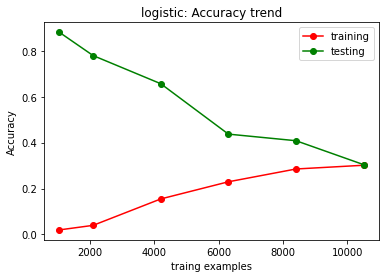

In [ ]:
learning_curve_plotting(Logistic_Model, features, categoryId, 'logistic')

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def KNN_classification(X_train, X_test, y_train, y_test, k, id2cat):
  # X_train.to(device)
  # y_train.to(device)
  # X_test.to(device)
  # y_test.to(device)
  KNN_Model = KNeighborsClassifier(n_neighbors = k)
  KNN_Model.fit(X_train, y_train)
  y_predict = KNN_Model.predict(X_test)

  return KNN_Model, y_predict

In [ ]:
KNN_Model, y_predict_knn = KNN_classification(X_train, X_test, y_train, y_test, 10, id2cat)

In [ ]:
evaluation(y_predict_knn, y_test, id2cat, model_name = "KNN")

KNN: acc:0.7530441400304414, recall:0.7392500342824618, f1 score:0.7535857078320571
                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.82      0.89      0.86        74
         Beer, Cider & Wine       0.90      0.94      0.92       249
 Chilled, Frozen & Desserts       0.67      0.54      0.60       294
                     Drinks       0.81      0.81      0.81       213
       Fresh Foods & Bakery       0.64      0.52      0.57       254
Kitchen, Dining & Household       0.77      0.70      0.73       239
                     Pantry       0.72      0.85      0.78       851
              Personal Care       0.79      0.73      0.76       342
                       Pets       0.87      0.67      0.76       112

                   accuracy                           0.75      2628
                  macro avg       0.78      0.74      0.75      2628
               weighted avg       0.75      0.75      0.75      2628



(6,)


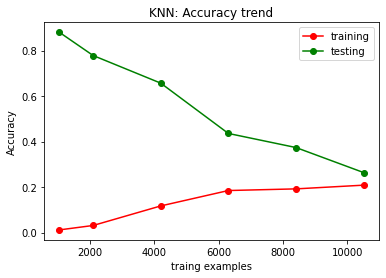

In [ ]:
learning_curve_plotting(KNN_Model, features, categoryId, 'KNN')

## SVM

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def SVM_classification(X_train, X_test, y_train, y_test, id2cat):
  # X_train.to(device)
  # y_train.to(device)
  # X_test.to(device)
  # y_test.to(device)
  SVC_Model = OneVsRestClassifier(SVC()) 
  SVC_Model.fit(X_train, y_train) 
  y_predict = SVC_Model.predict(X_test)
  
  return SVC_Model, y_predict

In [ ]:
SVM_Model, y_predict_svm = SVM_classification(X_train, X_test, y_train, y_test, id2cat)
# We find that SVM does not predict well on 'Meat Spot' 
# Tried several times whether continuously predict badly on this category
# What are the predictions for this category?
# Any information from those name?

In [ ]:
evaluation(y_predict_svm, y_test, id2cat, "svm")

svm: acc:0.7328767123287672, recall:0.6995692037054382, f1 score:0.7280240521363024
                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.78      0.88      0.83        74
         Beer, Cider & Wine       0.88      0.94      0.91       249
 Chilled, Frozen & Desserts       0.75      0.39      0.51       294
                     Drinks       0.91      0.67      0.77       213
       Fresh Foods & Bakery       0.73      0.29      0.42       254
Kitchen, Dining & Household       0.81      0.73      0.76       239
                     Pantry       0.62      0.91      0.74       851
              Personal Care       0.85      0.77      0.81       342
                       Pets       0.92      0.71      0.80       112

                   accuracy                           0.73      2628
                  macro avg       0.80      0.70      0.73      2628
               weighted avg       0.76      0.73      0.72      2628



In [ ]:
# meal_wrong_predict = [y_predict[i] for i in range(len(y_test)) if y_test[i] == cat2id['Meal Spot']]
# meal_wrong_percentage = {}

# for item in meal_wrong_predict:
#   if item not in list(meal_wrong_percentage.keys()):
#     meal_wrong_percentage[item] = 1
#   meal_wrong_percentage[item] += 1

# for item, value in meal_wrong_percentage.items():
#   print(f'{item}: {value/len(meal_wrong_predict) * 100:.2f} %'.format(item, value))

In [ ]:
# id2cat[max(meal_wrong_percentage, key = meal_wrong_percentage.get)]

(6,)


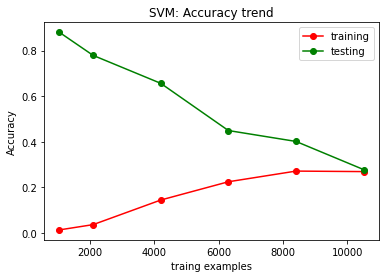

In [ ]:
learning_curve_plotting(SVM_Model, features, categoryId, 'SVM')

## GDBT

In [ ]:
import lightgbm as lgb

def lgb_classification(X_train, X_test, y_train, y_test, id2cat, verbose):
    params = {
    'num_leaves': 60,
    'min_data_in_leaf': 30,
    'objective': 'multiclass',
    'num_class': 33,
    'max_depth': -1,
    'learning_rate': 0.03,
    "min_sum_hessian_in_leaf": 6,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 15,
    'metric': 'multi_error',
    "random_state": 0
          }

    GDBT_Model = lgb.train(params
                      , lgb.Dataset(X_train, y_train)
                      , num_boost_round = 100000
                      , valid_sets = [lgb.Dataset(X_test, y_test)]
                      , verbose_eval = verbose
                      , early_stopping_rounds = 500
                     )

    print('Predicting...')
    y_prob = GDBT_Model.predict(X_test, num_iteration = GDBT_Model.best_iteration)
    y_predict = [list(x).index(max(x)) for x in y_prob]
    # print("AUC score: {:<8.5f}".format(metrics.accuracy_score(lgb_predict_labels, y_test)))
    # report = metrics.classification_report(y_test, lgb_predict_labels, target_names=[id2cat[i] for i in range(len(id2cat))])
    # print(report)
    
    return GDBT_Model, y_predict

In [ ]:
# from lightgbm import LGBMClassifier

# def GDBT(X_train, X_test, y_train, y_test, id2cat):
#   GDBT_Model = LGBMClassifier(
#       boosting_type = 'gdbt', 
#       num_leaves = 60, 
#       max_depth = -1, 
#       learning_rate = 0.1
#       )

In [ ]:
GDBT_Model, y_predict_gdbt = lgb_classification(X_train, X_test, y_train, y_test, id2cat, verbose=False)

Predicting...


In [ ]:
evaluation(y_predict_gdbt, y_test, id2cat, model_name='GDBT')

GDBT: acc:0.8424657534246576, recall:0.8440513916416348, f1 score:0.8469478835813754
                             precision    recall  f1-score   support

       Baby, Toddler & Kids       0.85      0.92      0.88        74
         Beer, Cider & Wine       0.87      0.97      0.92       249
 Chilled, Frozen & Desserts       0.78      0.68      0.73       294
                     Drinks       0.91      0.90      0.90       213
       Fresh Foods & Bakery       0.76      0.66      0.71       254
Kitchen, Dining & Household       0.88      0.80      0.84       239
                     Pantry       0.82      0.89      0.86       851
              Personal Care       0.89      0.85      0.87       342
                       Pets       0.91      0.93      0.92       112

                   accuracy                           0.84      2628
                  macro avg       0.85      0.84      0.85      2628
               weighted avg       0.84      0.84      0.84      2628



In [ ]:
# learning_curve_plotting(GDBT_Model, features, categoryId)

In [ ]:
# # 10-fold cross validation, print the average accuracy
# n = 10
# k = 50
# accuracy_list = []

# # Shuffle the dataset
# number = len(X_shuffle) // n

# for i in range(n):

#   # data split
#   # index for training and validation set
#   first_row = number * i
#   last_row = min(number * (i+1), len(X_train))
#   X_train_cross = X_train[:first_row].extend(X_train[last_row:])
#   y_train_cross = y_train[:first_row].extend(y_train[last_row:])


#   # train
#   classifier = KNeighborsClassifier(n_neighbors = k)
#   classifier.fit(X_train_cross, y_train_cross)


#   # accuracy
#   y_pred = classifier.predict(X_train[first_row:last_row])
#   accuracy = accuracy_score(y_train[first_row:last_row], y_pred)
#   accuracy_list.append(accuracy)